C:\Users\Hugo Troonbeeckx\AppData\Local\Temp\ipykernel_17580\1313840796.py:31: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, s = wavfile.read(file)


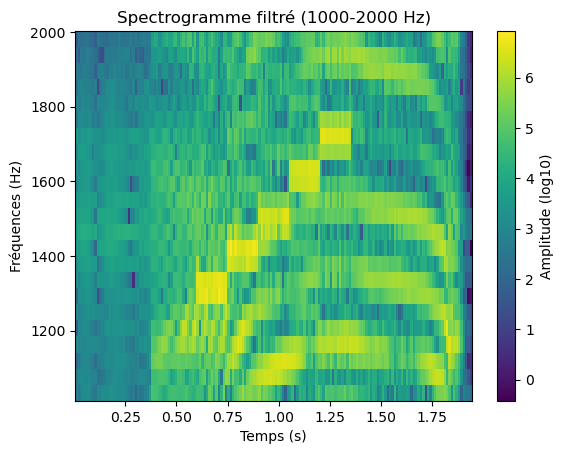

In [82]:
from scipy.signal import spectrogram
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

# Chargement des fichiers de référence
Fs, reference_hyper = wavfile.read('alarms/hyper.wav')
Fs, reference_hypo = wavfile.read('alarms/hypo.wav')

def convert_to_mono(s):
    if len(s.shape) == 2:  
        s = s.mean(axis=1) 
    return s

def filter_signal(s, Wn1, Wn2, type, Fs):
    Wn = [Wn1 / (Fs / 2), Wn2 / (Fs / 2)] 
    b, a = signal.butter(1, Wn, type) 
    s = signal.filtfilt(b, a, s)
    return s

def apply_filter(Fs, s):
    s = filter_signal(s, 1311, 1723, 'band', Fs)
    s = filter_signal(s, 1313, 1409, 'stop', Fs)
    s = filter_signal(s, 1411, 1499, 'stop', Fs)
    s = filter_signal(s, 1501, 1618, 'stop', Fs)
    s = filter_signal(s, 1620, 1721, 'stop', Fs)
    return s

def read_file(file):
    Fs, s = wavfile.read(file)
    s = convert_to_mono(s)
    return Fs, s

def filter_spectrogram(frequencies, spectrogram, freq_min, freq_max):
    """
    Filtre un spectrogramme pour ne conserver que les fréquences dans une plage donnée.
    """
    indices = (frequencies >= freq_min) & (frequencies <= freq_max)
    frequencies_filtered = frequencies[indices]
    spectrogram_filtered = spectrogram[indices, :]
    return frequencies_filtered, spectrogram_filtered

def display_spectrogram(Fs, s, freq_min=1000, freq_max=2000):
    """
    Affiche le spectrogramme d'un signal, filtré pour ne conserver que certaines fréquences.
    """
    f, t, Sxx = signal.spectrogram(s, Fs, window='hamming', nperseg=1024, noverlap=512)
    f_filtered, Sxx_filtered = filter_spectrogram(f, Sxx, freq_min, freq_max)
    
    # Affichage du spectrogramme filtré
    plt.pcolormesh(t, f_filtered, np.log10(Sxx_filtered + 1e-10))
    plt.ylabel('Fréquences (Hz)')
    plt.xlabel('Temps (s)')
    plt.title(f'Spectrogramme filtré ({freq_min}-{freq_max} Hz)')
    plt.colorbar(label='Amplitude (log10)')
    plt.show()

# Lecture et traitement du fichier d'entrée
Fs, s = read_file('alarms/hyper_vache.wav')
#s = apply_filter(Fs, s)

# Affichage des spectrogrammes
display_spectrogram(Fs, s)


C:\Users\Hugo Troonbeeckx\AppData\Local\Temp\ipykernel_17580\2949724205.py:26: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, s = wavfile.read(file)


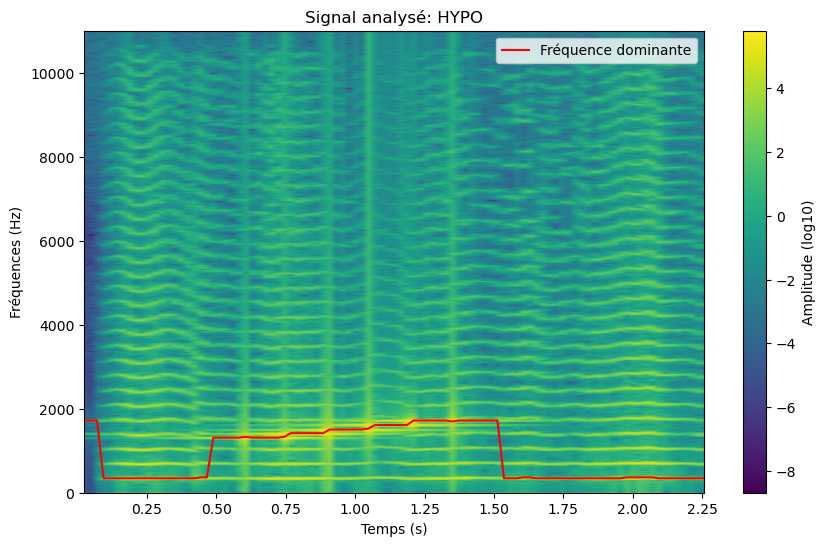

Le signal est classé comme: HYPO


In [48]:
from scipy.signal import spectrogram, butter, filtfilt
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour convertir un signal stéréo en mono
def convert_to_mono(s):
    if len(s.shape) == 2:
        s = s.mean(axis=1)
    return s

# Fonction pour appliquer un filtre passe-bande
def filter_signal(s, Fs, center_freq, bandwidth=2):
    nyquist = Fs / 2
    Wn1 = (center_freq - bandwidth) / nyquist
    Wn2 = (center_freq + bandwidth) / nyquist
    Wn = [Wn1, Wn2]
    
    b, a = signal.butter(1, Wn, btype='stop')
    s = signal.filtfilt(b, a, s)
    
    return s

# Fonction pour lire et préparer un fichier audio
def read_and_process(file):
    Fs, s = wavfile.read(file)
    s = convert_to_mono(s)
    frequencies = [1312, 1410, 1500, 1619, 1722] 
    
    for f in frequencies:
        s = filter_signal(s, Fs, f)
        
    return Fs, s

# Fonction pour extraire les fréquences dominantes
def extract_dominant_frequencies(frequencies, spectrogram):
    return [frequencies[np.argmax(col)] for col in spectrogram.T]

# Fonction pour afficher un spectrogramme et déterminer si le signal est hyper ou hypo
def analyze_signal(Fs, s):
    f, t, Sxx = spectrogram(s, Fs, window='hamming', nperseg=1024, noverlap=512)
    dominant_frequencies = extract_dominant_frequencies(f, Sxx)
    
    # Déterminer si les fréquences montent ou descendent
    trend = np.polyfit(t, dominant_frequencies, 1)[0]  # Calcul de la pente
    signal_type = "hyper" if trend > 0 else "hypo"

    # Affichage
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, np.log10(Sxx + 1e-10), shading='gouraud')
    plt.plot(t, dominant_frequencies, color='red', label='Fréquence dominante')
    plt.ylabel('Fréquences (Hz)')
    plt.xlabel('Temps (s)')
    plt.title(f'Signal analysé: {signal_type.upper()}')
    plt.colorbar(label='Amplitude (log10)')
    plt.legend()
    plt.show()
    
    return signal_type

# Lecture, traitement et analyse du fichier
Fs, s = read_and_process('alarms/moustique_hyper.wav')
signal_type = analyze_signal(Fs, s)

print(f"Le signal est classé comme: {signal_type.upper()}")


C:\Users\Hugo Troonbeeckx\AppData\Local\Temp\ipykernel_17580\1240968144.py:71: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, s = wavfile.read(file)


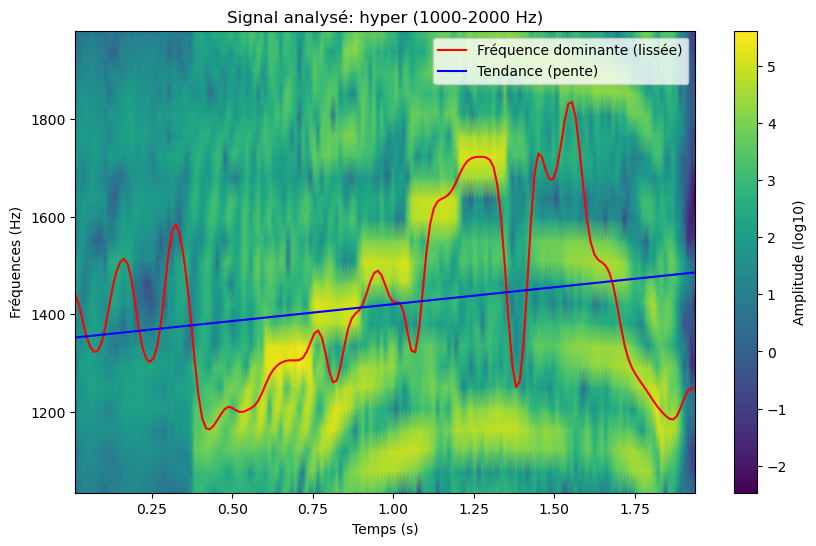

Pente calculée: 69.2778420233461
Le signal est classé comme: hyper


In [113]:
from scipy.signal import spectrogram, butter, filtfilt
from scipy.io import wavfile
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour convertir un signal stéréo en mono
def convert_to_mono(s):
    if len(s.shape) == 2:  
        s = s.mean(axis=1)  
    return s

# Fonction pour filtrer le signal
def filter_signal(s, Wn1, Wn2, type, Fs):
    Wn = [Wn1 / (Fs / 2), Wn2 / (Fs / 2)]
    b, a = butter(1, Wn, type)
    s = filtfilt(b, a, s)
    return s

# Fonction pour appliquer différents filtres au signal
def apply_filter(Fs, s):
    s = filter_signal(s, 1311, 1723, 'band', Fs) 
    s = filter_signal(s, 1313, 1409, 'stop', Fs)
    s = filter_signal(s, 1411, 1499, 'stop', Fs)  
    s = filter_signal(s, 1501, 1618, 'stop', Fs)  
    s = filter_signal(s, 1620, 1721, 'stop', Fs) 
    return s

# Filtrer les fréquences dans un spectrogramme
def filter_spectrogram(frequencies, spectrogram, freq_min, freq_max):
    indices = (frequencies >= freq_min) & (frequencies <= freq_max)
    frequencies_filtered = frequencies[indices]
    spectrogram_filtered = spectrogram[indices, :]
    return frequencies_filtered, spectrogram_filtered

# Fonction pour extraire les fréquences dominantes avec lissage
def extract_dominant_frequencies(frequencies, spectrogram):
    raw_dominants = [frequencies[np.argmax(col)] for col in spectrogram.T]
    smoothed_dominants = gaussian_filter1d(raw_dominants, sigma=2)  # Appliquer un lissage
    return smoothed_dominants

# Analyse du signal avec spectrogramme filtré
def analyze_signal(Fs, s, freq_min=1000, freq_max=2000):
    f, t, Sxx = spectrogram(s, Fs, window='hamming', nperseg=1024, noverlap=512)
    f_filtered, Sxx_filtered = filter_spectrogram(f, Sxx, freq_min, freq_max)
    
    # Extraction des fréquences dominantes après filtrage
    dominant_frequencies = extract_dominant_frequencies(f_filtered, Sxx_filtered)
    
    # Calcul de la pente de la tendance
    trend = np.polyfit(t, dominant_frequencies, 1)  # Ajustement linéaire
    signal_type = "hyper" if trend[0] > 0 else "hypo"

    # Affichage
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f_filtered, np.log10(Sxx_filtered + 1e-10), shading='gouraud')
    plt.plot(t, dominant_frequencies, color='red', label='Fréquence dominante (lissée)')
    plt.plot(t, np.polyval(trend, t), color='blue', label='Tendance (pente)')
    plt.ylabel('Fréquences (Hz)')
    plt.xlabel('Temps (s)')
    plt.title(f'Signal analysé: {signal_type} ({freq_min}-{freq_max} Hz)')
    plt.colorbar(label='Amplitude (log10)')
    plt.legend()
    plt.show()
    
    print(f"Pente calculée: {trend[0]}")
    
    return signal_type

def read_file(file):
    Fs, s = wavfile.read(file)
    s = convert_to_mono(s)
    s = apply_filter(Fs, s)  
    return Fs, s

Fs, s = read_file('alarms/hyper_vache.wav')
signal_type = analyze_signal(Fs, s, freq_min=1000, freq_max=2000)

print(f"Le signal est classé comme: {signal_type}")

C:\Users\Hugo Troonbeeckx\AppData\Local\Temp\ipykernel_17580\2135426848.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, s = wavfile.read(file)


Amplitude maximale à 1312 Hz : 2888198.00 à t = 0.67 s.
La pente des fréquences dominantes à partir de t = 0.67 s est -362.5844.


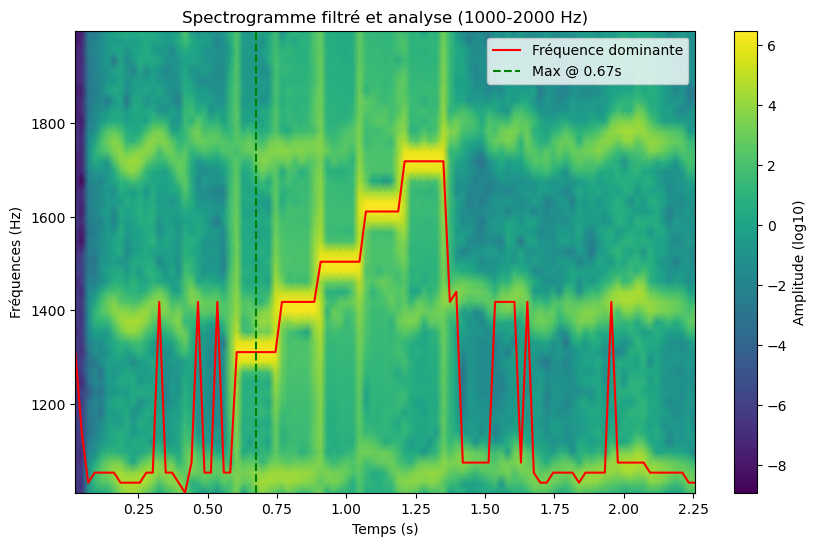

In [115]:
import numpy as np
from scipy.signal import spectrogram
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Fonctions existantes
def convert_to_mono(s):
    if len(s.shape) == 2:
        s = s.mean(axis=1)
    return s

def read_file(file):
    Fs, s = wavfile.read(file)
    s = convert_to_mono(s)
    return Fs, s

def filter_spectrogram(frequencies, spectrogram, freq_min, freq_max):
    indices = (frequencies >= freq_min) & (frequencies <= freq_max)
    frequencies_filtered = frequencies[indices]
    spectrogram_filtered = spectrogram[indices, :]
    return frequencies_filtered, spectrogram_filtered

# Nouvelle fonction pour trouver l'instant t et l'amplitude maximale à une fréquence donnée
def find_max_amplitude_at_frequency(f, t, Sxx, target_frequency):
    """
    Trouve l'instant t où l'amplitude est maximale pour une fréquence donnée dans un spectrogramme.
    """
    freq_index = np.abs(f - target_frequency).argmin()
    amplitude_at_freq = Sxx[freq_index, :]
    max_index = np.argmax(amplitude_at_freq)
    t_max = t[max_index]
    max_amplitude = amplitude_at_freq[max_index]
    return t_max, max_amplitude

# Nouvelle fonction pour calculer la pente à partir d'un instant donné
def calculate_slope_from_time(frequencies, spectrogram, t, dominant_frequencies, start_time):
    """
    Calcule la pente des fréquences dominantes à partir d'un instant donné.
    """
    start_index = np.abs(t - start_time).argmin()  # Trouve l'indice correspondant à start_time
    t_segment = t[start_index:]
    dominant_segment = dominant_frequencies[start_index:]
    
    # Ajustement linéaire (calcul de la pente)
    slope, intercept = np.polyfit(t_segment, dominant_segment, 1)
    return slope

# Fonction pour extraire les fréquences dominantes
def extract_dominant_frequencies(frequencies, spectrogram):
    return [frequencies[np.argmax(col)] for col in spectrogram.T]

# Fonction principale d'affichage
def analyze_signal(Fs, s, target_frequency=1312, freq_min=1000, freq_max=2000):
    # Calcul du spectrogramme
    f, t, Sxx = spectrogram(s, Fs, window='hamming', nperseg=1024, noverlap=512)
    f_filtered, Sxx_filtered = filter_spectrogram(f, Sxx, freq_min, freq_max)
    
    # Extraire l'instant où l'amplitude est maximale à target_frequency
    t_max, max_amplitude = find_max_amplitude_at_frequency(f_filtered, t, Sxx_filtered, target_frequency)
    print(f"Amplitude maximale à {target_frequency} Hz : {max_amplitude:.2f} à t = {t_max:.2f} s.")
    
    # Extraire les fréquences dominantes
    dominant_frequencies = extract_dominant_frequencies(f_filtered, Sxx_filtered)
    
    # Calcul de la pente des fréquences dominantes à partir de t_max
    slope = calculate_slope_from_time(f_filtered, Sxx_filtered, t, dominant_frequencies, t_max)
    print(f"La pente des fréquences dominantes à partir de t = {t_max:.2f} s est {slope:.4f}.")
    
    # Affichage du spectrogramme et des fréquences dominantes
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f_filtered, np.log10(Sxx_filtered + 1e-10), shading='gouraud')
    plt.plot(t, dominant_frequencies, color='red', label='Fréquence dominante')
    plt.axvline(x=t_max, color='green', linestyle='--', label=f'Max @ {t_max:.2f}s')
    plt.ylabel('Fréquences (Hz)')
    plt.xlabel('Temps (s)')
    plt.title(f"Spectrogramme filtré et analyse ({freq_min}-{freq_max} Hz)")
    plt.colorbar(label='Amplitude (log10)')
    plt.legend()
    plt.show()

# Lecture et analyse du signal
Fs, s = read_file('alarms/moustique_hyper.wav')
analyze_signal(Fs, s, target_frequency=1312, freq_min=1000, freq_max=2000)


C:\Users\Hugo Troonbeeckx\AppData\Local\Temp\ipykernel_13412\1487301393.py:30: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, s = wavfile.read(file)


Amplitude maximale à 1312 Hz : 54191.51 à t = 1.34 s.
Amplitude maximale à 1410 Hz : 129913.13 à t = 1.07 s.
Amplitude maximale à 1500 Hz : 306933.56 à t = 0.94 s.
Amplitude maximale à 1619 Hz : 166044.70 à t = 0.87 s.
Amplitude maximale à 1722 Hz : 312086.20 à t = 0.72 s.
Le signal est classé comme : hypo


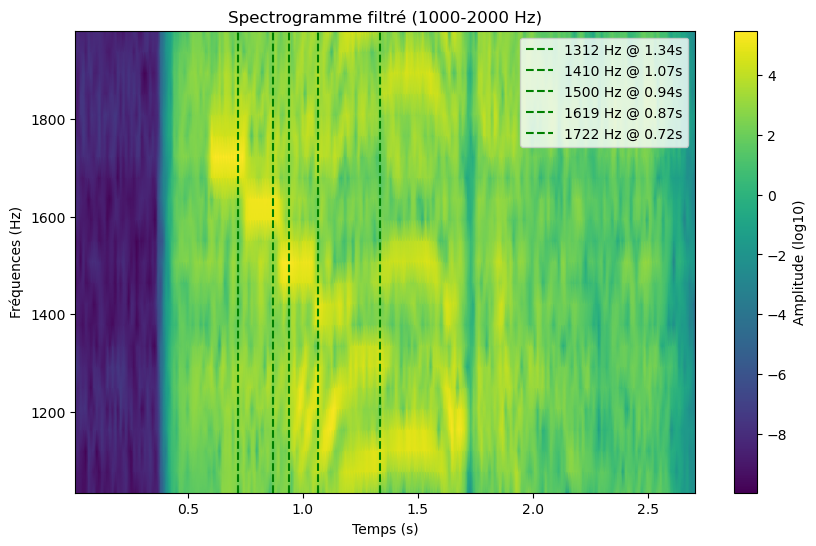

In [93]:
import numpy as np
from scipy.signal import spectrogram, butter, filtfilt
from scipy.io import wavfile
import matplotlib.pyplot as plt

target_frequencies = [1312, 1410, 1500, 1619, 1722]

def convert_to_mono(s):
    if len(s.shape) == 2:
        s = s.mean(axis=1)
    return s

# Fonction pour filtrer le signal
def filter_signal(s, Wn1, Wn2, type, Fs):
    Wn = [Wn1 / (Fs / 2), Wn2 / (Fs / 2)]
    b, a = butter(1, Wn, type)
    s = filtfilt(b, a, s)
    return s

# Fonction pour appliquer différents filtres au signal
def apply_filter(Fs, s):
    s = filter_signal(s, 1311, 1723, 'band', Fs) 
    s = filter_signal(s, 1313, 1409, 'stop', Fs)
    s = filter_signal(s, 1411, 1499, 'stop', Fs)  
    s = filter_signal(s, 1501, 1618, 'stop', Fs)  
    s = filter_signal(s, 1620, 1721, 'stop', Fs) 
    return s

def read_file(file):
    Fs, s = wavfile.read(file)
    s = convert_to_mono(s)
    s = apply_filter(Fs, s)
    return Fs, s

def filter_spectrogram(frequencies, spectrogram, freq_min, freq_max):
    indices = (frequencies >= freq_min) & (frequencies <= freq_max)
    return frequencies[indices], spectrogram[indices, :]

def find_max_amplitude(f, t, Sxx, target_frequencies):
    results = []
    for target_frequency in target_frequencies:
        freq_index = np.abs(f - target_frequency).argmin()
        amplitude_at_freq = Sxx[freq_index, :]
        max_index = np.argmax(amplitude_at_freq)
        results.append((target_frequency, t[max_index], amplitude_at_freq[max_index]))
    return results

def classify_signal(max_amplitudes, target_frequencies):
    times = [t_max for _, t_max, _ in max_amplitudes]
    
    if times == sorted(times):
        return "hyper"
    elif times == sorted(times, reverse=True):
        return "hypo"
    else:
        return "indéterminé"  

def analyze_signal(Fs, s, target_frequencies, freq_min=1000, freq_max=2000):
    f, t, Sxx = spectrogram(s, Fs, window='hamming', nperseg=1024, noverlap=512)
    f_filtered, Sxx_filtered = filter_spectrogram(f, Sxx, freq_min, freq_max)
    
    # Trouver les instants où l'amplitude est maximale pour chaque fréquence cible
    max_amplitudes = find_max_amplitude(f_filtered, t, Sxx_filtered, target_frequencies)
    
    # Affichage des résultats
    for target_frequency, t_max, max_amplitude in max_amplitudes:
        print(f"Amplitude maximale à {target_frequency} Hz : {max_amplitude:.2f} à t = {t_max:.2f} s.")
    
    # Classifier le signal
    signal_class = classify_signal(max_amplitudes, target_frequencies)
    print(f"Le signal est classé comme : {signal_class}")
    
    # Affichage du spectrogramme et des instants t_max
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f_filtered, np.log10(Sxx_filtered + 1e-10), shading='gouraud')
    
    # Tracer les lignes vertes pour chaque instant t_max
    for target_frequency, t_max, _ in max_amplitudes:
        plt.axvline(x=t_max, color='green', linestyle='--', label=f'{target_frequency} Hz @ {t_max:.2f}s')
    
    plt.ylabel('Fréquences (Hz)')
    plt.xlabel('Temps (s)')
    plt.title(f"Spectrogramme filtré ({freq_min}-{freq_max} Hz)")
    plt.colorbar(label='Amplitude (log10)')
    plt.legend()
    plt.show()

# Lecture et analyse du signal
Fs, s = read_file('alarms/new/hypo_vache_20DB.wav')
analyze_signal(Fs, s, target_frequencies)